#Telco Churn

##Librerie

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sl
import seaborn as sns

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

print(tf.__version__)
print(pd.__version__)
print(np.__version__)
print(sl.__version__)
print(sns.__version__)

2.2.0
1.0.4
1.18.5
0.22.2.post1
0.10.1


In [ ]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures

## Dataset

In [ ]:
url = 'https://raw.githubusercontent.com/rirolli/TelcoChurn/master/Telco-Customer-Churn-train.csv'

telco_data = pd.read_csv(url, na_values=np.nan)

In [ ]:
# Stampa delle prime 10 righe del dataset
telco_data.head(10)

,Churn,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,No,4223-BKEOR,Female,0,No,Yes,21,Yes,No,DSL,Yes,No,Yes,No,No,Yes,One year,No,Mailed check,64.85,1336.8
1,No,6035-RIIOM,Female,0,No,No,54,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),97.20,5129.45
2,Yes,3797-VTIDR,Male,0,Yes,No,1,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,23.45,23.45
3,Yes,2568-BRGYX,Male,0,No,No,4,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.20,237.95
4,No,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,
5,No,4291-SHSBH,Male,0,No,No,7,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,69.55,521.35
6,No,4635-EJYPD,Male,0,Yes,Yes,32,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,18.95,613.95
7,No,2607-DHDAK,Male,0,Yes,Yes,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),19.80,1414.65
8,Yes,5204-QZXPU,Male,0,No,No,19,No,No phone service,DSL,No,No,Yes,No,Yes,No,Month-to-month,Yes,Electronic check,39.65,733.35
9,No,0221-NAUXK,Male,0,No,Yes,10,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic),19.95,219.5


###Analisi del dataset

La prima cosa da fare è scoprire qual è la forma del dataset:

In [ ]:
# Numero di righe e colonne nel dataset
print(f"Shape: {telco_data.shape}")
print(f"Numero di righe (utenti telefonici): {telco_data.shape[0]}")
print(f"Numero di colonne: {telco_data.shape[1]}")

Shape: (5634, 21)
Numero di righe (utenti telefonici): 5634
Numero di colonne: 21


Vediamo di che tipo sono ogni colonna del dataset:

In [ ]:
telco_data.dtypes

Churn                object
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object

Poi si procede con il vedere se ci sono delle righe con valori non validi (NaN):

In [ ]:
# Sostituisco ad ogni stringa vuola il valore 'NaN'
telco_data.replace("", np.nan, inplace=True)
telco_data.replace(" ", np.nan, inplace=True)
telco_data.replace("?", np.nan, inplace=True)

In [ ]:
# Controllo dei dati non validi (NaN) nel dataset
telco_data.isna().sum()

Churn                0
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        10
dtype: int64

Ora vediamo un po' di statistiche e grafici del dataset.

In [ ]:
# Statistiche
telco_data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,5634.000000,5634.000000,5634.000000
mean,0.160809,32.373092,64.864253
std,0.367388,24.424539,30.089324
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.750000
50%,0.000000,29.000000,70.525000
75%,0.000000,55.000000,89.937500
max,1.000000,72.000000,118.600000


In [ ]:
# Numero dei churn
telco_data['Churn'].value_counts()

No     4138
Yes    1496
Name: Churn, dtype: int64

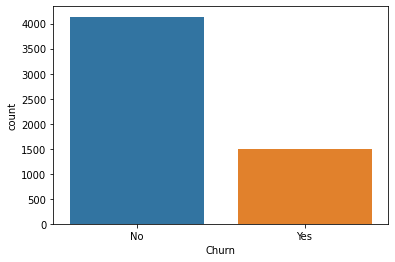

In [ ]:
# Diagramma che confronta le persone che hanno lasciato la compagnia telefonica
sns.countplot(telco_data['Churn'])

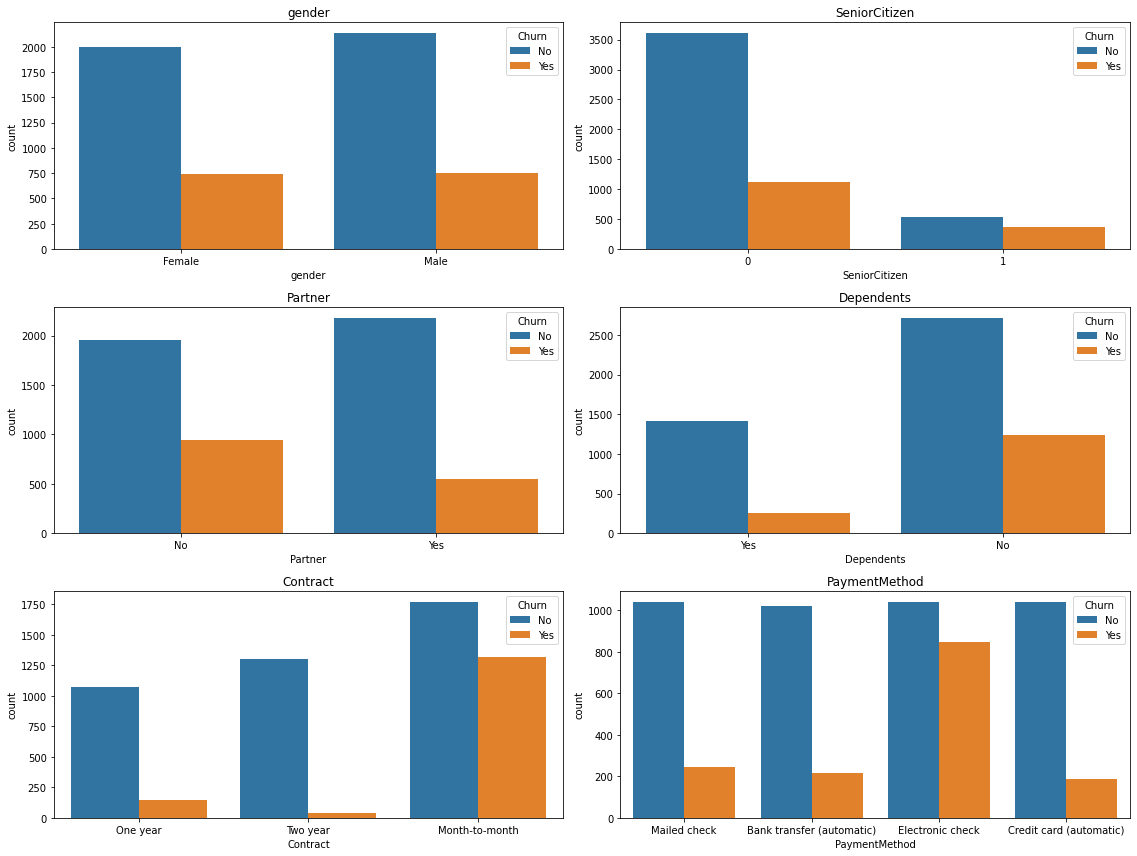

In [ ]:
# Alcuni grafici che mettono in relazione le features
# del dataset con le persone che hanno lasciato la compagnia

cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Contract', 'PaymentMethod']

n_rows = 3
n_cols = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*8, n_rows*4))
i=0
for r in range(n_rows):
  for c in range(n_cols):
    ax = axs[r][c]
    sns.countplot(telco_data[cols[i]], hue=telco_data['Churn'], ax=ax)
    ax.set_title(cols[i])
    ax.legend(title='Churn', loc='upper right')
    i+=1

plt.tight_layout()

In [ ]:
for val in telco_data:
  print(telco_data[val].value_counts())
  print()

No     4138
Yes    1496
Name: Churn, dtype: int64

0141-YEAYS    1
9584-EXCDZ    1
4614-NUVZD    1
3793-MMFUH    1
3457-PQBYH    1
             ..
0979-PHULV    1
8327-LZKAS    1
0439-IFYUN    1
2398-YPMUR    1
2480-JZOSN    1
Name: customerID, Length: 5634, dtype: int64

Male      2887
Female    2747
Name: gender, dtype: int64

0    4728
1     906
Name: SeniorCitizen, dtype: int64

No     2904
Yes    2730
Name: Partner, dtype: int64

No     3951
Yes    1683
Name: Dependents, dtype: int64

1     476
72    286
2     174
3     161
4     147
     ... 
44     46
39     43
36     43
45     43
0      10
Name: tenure, Length: 73, dtype: int64

Yes    5082
No      552
Name: PhoneService, dtype: int64

No                  2685
Yes                 2397
No phone service     552
Name: MultipleLines, dtype: int64

Fiber optic    2481
DSL            1939
No             1214
Name: InternetService, dtype: int64

No                     2810
Yes                    1610
No internet service    1214
Name: 

###Operazione di preprocessing del dataset

La prima operazione da fare è quella di eliminare tutte le righe che contengono almeno un valore NaN:

In [ ]:
# Procediamo con l'eliminazione dei dati non validi (NaN)
telco_data.dropna(inplace=True)

In [ ]:
# Controlliamo che non vi siano più nessun valore nullo
telco_data.isna().sum()

Churn               0
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [ ]:
# stampa della nuova shape dopo l'eliminazione delle righe non valide
print(f"Shape: {telco_data.shape}")
print(f"Numero di righe (utenti telefonici): {telco_data.shape[0]}")
print(f"Numero di colonne: {telco_data.shape[1]}")

Shape: (5624, 21)
Numero di righe (utenti telefonici): 5624
Numero di colonne: 21


Successivamente si procede con l'operazione di codifica del dataset.

In [ ]:
# codifica di tutti i dati del dataset
for elem in telco_data:
  telco_data[elem] = (pd.Categorical(telco_data[elem])).codes

In [ ]:
# Stampa delle prime 10 righe del dataset codificato
telco_data.head(10)

,Churn,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,2364,0,0,0,1,20,1,0,0,2,0,2,0,0,2,1,0,3,585,491
1,0,3448,0,0,0,0,53,1,2,1,0,2,0,0,2,2,2,1,0,1169,3510
2,1,2143,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,2,59,1565
3,1,1424,1,0,0,0,3,1,0,1,0,0,0,0,0,0,0,1,2,673,1626
5,0,2394,1,0,0,0,6,1,0,1,0,0,0,0,0,0,0,1,2,660,3548
6,0,2593,1,0,1,1,31,1,0,2,1,1,1,1,1,1,2,0,3,7,4047
7,0,1446,1,0,1,1,71,1,0,2,1,1,1,1,1,1,2,1,1,24,613
8,1,2953,1,0,0,0,18,0,1,0,0,0,2,0,2,0,0,1,2,217,4612
9,0,103,1,0,0,1,9,1,0,2,1,1,1,1,1,1,1,1,0,27,1457
10,1,1911,1,1,1,0,20,1,0,1,0,0,0,0,0,0,0,1,2,651,697


###Ripartizione del dataset

Scegliamo le features che vogliamo usare per addestrare la rete neurale.

In [ ]:
# Elimino dal dataset, tramite la funzione frop(), tutte le colonne ritenute "inutili"
# ai fini dell'addestramento del modello. Le colonne rimanenti sono:
# 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'Contract', 
# 'PaperlessBilling', 'PaymentMethod', 'TotalCharges'
telco_data = telco_data.drop(['customerID', 'gender', 'tenure','PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'], axis=1)

Eseguiamo lo split del dataset

In [ ]:
# Dividiamo il train set in due parti così da poter addestrare la rete:
# y che contiene solo la colonna 'Churn' che consiste nella soluzione al problema
# X che contiene tutte le altre colonne specificate in 'features'.
y = telco_data.Churn
X = telco_data

# Il dataset viene nuovamente diviso in altre parti:
# train_X e train_y che sono le parti usate per l'addestramento;
# val_X e val_y che contengono le parti per la valutazione della rete;
# test_X e test_y per effettuare le predizioni e assicurarsi il corretto
# funzionamento. 
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=.2)
train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=.1)

# I dati vengono poi memorizzati dentro un Dataset di Tensorflow per sfruttarli
# per l'addestramento. Questa stessa operazione viene poi fatta anche per il
# test set e per l'evaluetion set.
train_dataset = (tf.data.Dataset.from_tensor_slices((train_X.values, train_y.values))).shuffle(len(train_X)).batch(1)
val_dataset = (tf.data.Dataset.from_tensor_slices((val_X.values, val_y.values))).shuffle(len(val_X)).batch(1)
test_dataset = (tf.data.Dataset.from_tensor_slices(test_X.values)).batch(1)

In [ ]:
print(val_X.shape)

(1125, 9)


##Il modello

Definiamo il modello da utilizzare:

###Linear Regression

In [ ]:
model_lr = LinearRegression()

model_lr.fit(train_X, train_y)
score_lr = model_lr.score(train_X, train_y)

predict_lr = model_lr.predict(val_X)
acc_lr = accuracy_score(val_y, predict_lr.round())

print(f"Training accuracy LinearRegression:\t{score_lr:.4f}\nValuation accuracy LinearRegression:\t{acc_lr:.4f}")

pred_lr = model_lr.predict(test_X)
accPred_lr = accuracy_score(test_y, pred_lr.round())
print(f"Test accuracy LinearRegression:\t\t{accPred_lr:.4f}")

Training accuracy LinearRegression:	1.0000
Valuation accuracy LinearRegression:	1.0000
Test accuracy LinearRegression:		1.0000


In [ ]:
print(confusion_matrix(test_y, pred_lr.round(), normalize=None))

[[317   0]
 [  0 133]]


###Decision Tree Regression

In [ ]:
model_dr = DecisionTreeRegressor(random_state=1)

model_dr.fit(train_X, train_y)
score_dr = model_dr.score(train_X, train_y)

predict_dr = model_dr.predict(val_X)
acc_dr = accuracy_score(val_y, predict_dr.round())

print(f"Training accuracy DecisionTreeRegression:\t{score_dr:.4f}\nValuation accuracy DecisionTreeRegression:\t{acc_dr:.4f}")

pred_dr = model_dr.predict(test_X)
accPred_dr = accuracy_score(test_y, pred_dr.round())
print(f"Test accuracy DecisionTreeRegression:\t\t{accPred_dr:.4f}")

Training accuracy DecisionTreeRegression:	1.0000
Valuation accuracy DecisionTreeRegression:	1.0000
Test accuracy DecisionTreeRegression:		1.0000


In [ ]:
print(confusion_matrix(test_y, pred_dr.round(), normalize=None))

[[317   0]
 [  0 133]]


###Ridge

In [ ]:
model_rr = Ridge()

model_rr.fit(train_X, train_y)
score_rr = model_rr.score(train_X, train_y)

predict_rr = model_rr.predict(val_X)
acc_rr = accuracy_score(val_y, predict_rr.round())

print(f"Training accuracy Ridge:\t{score_rr:.4f}\nValidation accuracy Ridge:\t{acc_rr:.4f}")

pred_rr = model_rr.predict(test_X)
accPred_rr = accuracy_score(test_y, pred_rr.round())
print(f"Test accuracy Ridge:\t\t{accPred_rr:.4f}")

Training accuracy Ridge:	1.0000
Validation accuracy Ridge:	1.0000
Test accuracy Ridge:		1.0000


In [ ]:
print(confusion_matrix(test_y, pred_rr.round(), normalize=None))

[[317   0]
 [  0 133]]


###Decision Tree Classifier

In [ ]:
model_dc = DecisionTreeClassifier()

model_dc.fit(train_X, train_y)
score_dc = model_dc.score(train_X, train_y)

predict_dc = model_dc.predict(val_X)
acc_dc = accuracy_score(val_y, predict_dc.round())

print(f"Training accuracy DecisionTreeClassifier:\t{score_dc:.4f}\nValidation accuracy DecisionTreeClassifier:\t{acc_dc:.4f}")

pred_dc = model_dc.predict(test_X)
accPred_dc = accuracy_score(test_y, pred_dc.round())
print(f"Test accuracy DecisionTreeClassifier:\t\t{accPred_dc:.4f}")

Training accuracy DecisionTreeClassifier:	1.0000
Validation accuracy DecisionTreeClassifier:	1.0000
Test accuracy DecisionTreeClassifier:		1.0000


In [ ]:
print(confusion_matrix(test_y, pred_dc.round(), normalize=None))

[[317   0]
 [  0 133]]


###K-Neighbors Classifier

In [ ]:
model_kc = KNeighborsClassifier()

model_kc.fit(train_X, train_y)
score_kc = model_kc.score(train_X, train_y)

predict_kc = model_kc.predict(val_X)
acc_kc = accuracy_score(val_y, predict_kc.round())

print(f"Training accuracy KNeighborsClassifier:\t\t{score_kc:.4f}\nValidation accuracy KNeighborsClassifier:\t{acc_kc:.4f}")

pred_kc = model_kc.predict(test_X)
accPred_kc = accuracy_score(test_y, pred_kc.round())
print(f"Test accuracy KNeighborsClassifier:\t\t{accPred_kc:.4f}")

Training accuracy KNeighborsClassifier:		0.8172
Validation accuracy KNeighborsClassifier:	0.7351
Test accuracy KNeighborsClassifier:		0.7156


In [ ]:
print(confusion_matrix(test_y, pred_kc.round(), normalize=None))

[[278  39]
 [ 89  44]]


###Neural Network

In [ ]:
num_inputs = X.shape[1]

In [ ]:
model_rn = keras.Sequential([
  tf.keras.layers.Dense(128, input_dim=num_inputs, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1)
])

model_rn.summary()

model_rn.compile(optimizer='adam',
                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 metrics=['accuracy'])

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 128)               1280      
_________________________________________________________________
dense_100 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 129       
Total params: 17,921
Trainable params: 17,921
Non-trainable params: 0
_________________________________________________________________


####Addestramento della rete neurale

In [ ]:
# Addestramento della rete neurale
model_rn.fit(train_dataset, epochs=20)

Epoch 1/20
4049/4049 [==============================] - 7s 2ms/step - loss: 10.0755 - accuracy: 0.6402
Epoch 2/20
4049/4049 [==============================] - 7s 2ms/step - loss: 1.0945 - accuracy: 0.6999
Epoch 3/20
4049/4049 [==============================] - 7s 2ms/step - loss: 0.5744 - accuracy: 0.7382
Epoch 4/20
4049/4049 [==============================] - 7s 2ms/step - loss: 0.4689 - accuracy: 0.7753
Epoch 5/20
4049/4049 [==============================] - 7s 2ms/step - loss: 0.3275 - accuracy: 0.8760
Epoch 6/20
4049/4049 [==============================] - 7s 2ms/step - loss: 0.1938 - accuracy: 0.9306
Epoch 7/20
4049/4049 [==============================] - 6s 2ms/step - loss: 0.2210 - accuracy: 0.9271
Epoch 8/20
4049/4049 [==============================] - 6s 2ms/step - loss: 0.1567 - accuracy: 0.9491
Epoch 9/20
4049/4049 [==============================] - 7s 2ms/step - loss: 0.3897 - accuracy: 0.8456
Epoch 10/20
4049/4049 [==============================] - 7s 2ms/step - loss: 0.46

####Valutazione della rete neurale

In [ ]:
# Valutazione della rete neurale
val_loss, val_acc = model_rn.evaluate(val_dataset)
print("\nTest accuracy: {:.4f} ({:.2%})\nTest loss: {:.4f}".format(val_acc, val_acc, val_loss))

1125/1125 [==============================] - 2s 1ms/step - loss: 6.9563e-04 - accuracy: 1.0000

Test accuracy: 1.0000 (100.00%)
Test loss: 0.0007


####Predizione tramite la rete neurale

In [ ]:
# Predizione dei dati tramite la rete neurale
predictions = model_rn.predict(test_dataset)
print("Accuracy prediction: {:.4f}".format(accuracy_score(test_y, tf.round(tf.sigmoid(predictions)).numpy())))

Accuracy prediction: 1.0000


####Confusion Matrix

In [ ]:
print(confusion_matrix(test_y, tf.round(tf.sigmoid(predictions)).numpy(), normalize=None))

[[317   0]
 [  0 133]]
